<font size=6>Problem 3</font>


**Read the whole notebook and the TODO action items are given in <font color=blue>blue.</font>**

First, let us import certain libraries that we will use in this notebook. To install these use `pip install <package>` or `conda install <package>` commands in terminal.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# let's you plot within the notebook
%matplotlib inline 

In [2]:
import torch
import torch.nn as nn
from torch import optim

Following are some functions to generate, plot, and evaluate the dataset. You can leave them unmodified.

In [3]:
def generate_planar_dataset_1():
    m = 200 # number of examples
    N = int(m/2) # number of points per class
    D = 2 # dimensionality
    X = np.zeros((m,D)) # data matrix where each row is a single example
    Y = np.zeros((m,1), dtype=np.int) # labels vector (0 for red, 1 for blue)
    a = 4 # maximum ray of the flower

    for j in range(2):
        ix = range(N*j,N*(j+1))
        t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*0.2 # theta
        r = a*np.sin(4*t) + np.random.randn(N)*0.2 # radius
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        Y[ix] = -1 if j==0 else 1
    X = X
    Y = Y.T[0]
    return X, Y

In [4]:
def plot_decision_boundary(model, X, Y):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model.predict(torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()]))
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.5)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[:, 0], X[:, 1], c=Y, s=40,cmap=plt.cm.Spectral)
    plt.show()

In [5]:
def get_accuracy(model, X, true_labels):
    return torch.mean((torch.squeeze(model.predict(X),1) == true_labels).float())

The rest of the notebook is arranged into numbered sections:
1. Models
2. Datasets
3. Training and Evaluation

# Models
In this section, we will define different Machine learning models using the torch library. Each model is defined as a python class with attributes corresponding to the weight parameters and the following functions:
- forward: Given an input x, this function applies the weight parameters of the model to a real valued score
- predict_probability: This function applies a sigmoid function to map the score to a probability representing P(y|x)
- predict: This function maps the probability to one of the labels $\{-1, +1\}$.

## Logistic Regression as 1-layer NN

We start with stating a simple logistic regression model as a 1-layer Neural network i.e. mapping the input to an output using a weight vector $w$

In [6]:
class LogRegModel(nn.Module):
    def __init__(self):
        super(LogRegModel, self).__init__()
        """
        a linear layer in torch.nn is a function from the input dimension (d=2 in our case)
        to a 1-d score along with a bias term
        """
        self.w = nn.Linear(2, 1, bias=True) 
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # transform the input using the weight vector: w^T x
        return self.w(x)
    
    def predict_probability(self, x):
        # convert the score to probability: 1/1+exp(-w^Tx)
        return self.sigmoid(self.forward(x))
    
    def predict(self, x):
        # map probability to a label in {-1,+1}
        return 2 * (self.predict_probability(x).ge(0.5).float() - 0.5)

## One-hidden-layer Neural Network 

Note that for a neural network with one hidden layer, we would have to create two weight vectors. Along with that we will also initialize an activation function. In our case, we will use a ReLU function which stands for Rectified Linear Unit and is defined as $max(0,x)$ to add non-linearity to the model.

In [7]:
class NNModel(nn.Module):
    def __init__(self, hidden_layer=4):
        super(NNModel, self).__init__()
        self.w1 = nn.Linear(2, hidden_layer, bias=True)
        # we use a ReLU activation function. However, you can try replacing it with other
        # non-linear functions as well. 
        self.activation = nn.ReLU()
        self.w2 = nn.Linear(hidden_layer, 1, bias=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # transform the input using the weight vectors and activation function
        # corresponds to: w_2^T (ReLU(w_1^T x))
        return self.w2(self.activation(self.w1(x)))
        
    def predict_probability(self, x):
        # convert the score to probability
        return self.sigmoid(self.forward(x))
    
    def predict(self, x): 
        # map probability to a label in {-1,+1}
        return 2 * (self.predict_probability(x).ge(0.5).float() - 0.5)

## 3-hidden-layer Neural Network

Finally, we create a neural network model with three hidden layers. The number of hidden units (nodes) in each layer are given as an option to the initialization function.

<font color=blue size=4>*(i)* Complete the code for the forward function below to compute the output of the 3-layer neural network. Use the one hidden layer neural network implementation from above as a guidance. </font>


In [8]:
class DeepNNModel(nn.Module):
    def __init__(self, hidden_layers=[4,4,4], D=2):
        super(DeepNNModel, self).__init__()
        # in this case, we define 4 weight vectors for 3 layers. 
        self.w1 = nn.Linear(D, hidden_layers[0], bias=True)
        self.w2 = nn.Linear(hidden_layers[0], hidden_layers[1], bias=True)
        self.w3 = nn.Linear(hidden_layers[1], hidden_layers[2], bias=True)
        self.w4 = nn.Linear(hidden_layers[2], 1, bias=True)
        self.activation = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # successively apply the layers and activation function one after the other.
        """
        FILL IN CODE HERE
        """
        # return the final 1-d output
        
    def predict_probability(self, x):
        return self.sigmoid(self.forward(x))
    
    def predict(self, x): 
        return 2 * (self.predict_probability(x).ge(0.5).float() - 0.5)

# Datasets

Now, let's construct three datasets: one where a linear separating hyperplane exists, and two where no linear separating hyperplanes exist. 

- Dataset 0: Two separable clusters
- Dataset 1: Moons dataset
- Dataset 2: Flower dataset


## Dataset 0

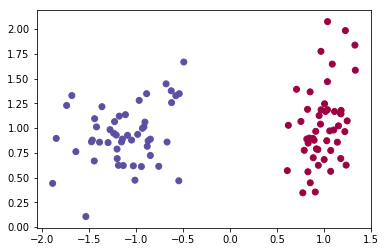

In [10]:
from sklearn.datasets import make_classification

X0, Y0 = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           random_state=1, class_sep=1, n_clusters_per_class=1)
plt.scatter(X0[:, 0], X0[:, 1], c=Y0, cmap=plt.cm.Spectral)
X0 = torch.FloatTensor(X0)
Y0 = torch.FloatTensor(Y0)
Y0 = 2 * (Y0-0.5)
plt.show()

## Dataset 1

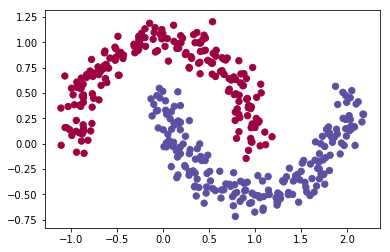

In [11]:
from sklearn.datasets import make_moons
X, Y = make_moons(n_samples=400, shuffle=False, noise=0.1)
X = torch.FloatTensor(X)
Y = torch.FloatTensor(Y)
Y = 2 * (Y-0.5)
# Visualize the data:
plt.scatter(X[:, 0], X[:, 1], c=Y, s=40,cmap=plt.cm.Spectral);

## Dataset 2

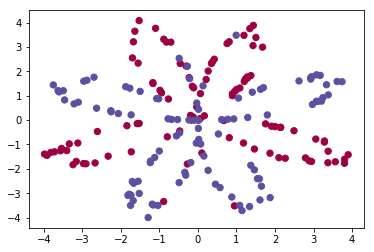

In [12]:
X2, Y2 = generate_planar_dataset_1()
X2 = torch.FloatTensor(X2)
Y2 = torch.FloatTensor(Y2)
# Visualize the data:
plt.scatter(X2[:, 0], X2[:, 1], c=Y2, s=40,cmap=plt.cm.Spectral);

# Training

We will fix the number of epochs to 10. Epochs is the number of passes over the entire dataset.

For training, we iterate over the entire dataset shuffled into a random order.\\

For each step, we compute the loss function using torch operations (see below), and torch does the backpropagation magic i.e. computing the gradient and updating the variables. 

In [13]:
num_epochs = 10

## Dataset 0

Let's fit a few different linear classification models on this dataset

### Training a Logistic Regression Model

In [14]:
# Read the comments below to understand the code

Notice that the loss function used below is the logistic loss and we train the LogRegModel using gradient descent. 
$$
L(h_w| X,Y) = \sum_{i=1}^N \log\left(1 + \exp\left(- y.h_w(x)\right)\right)
$$

In [15]:
model = LogRegModel()

lr = 0.1

# We use an Adam optimizer which updates the model parameters using the gradient 
# and some history of gradient information
# You can try different values of the learning rate to see what effect they have on the output
optimizer = optim.Adam(model.parameters(), lr=lr) 

for epoch in range(num_epochs):
    indices = torch.randperm(len(Y0))
    
    for i in range(len(Y0)):
        x, y = X0[indices[i]], Y0[indices[i]]
        
        optimizer.zero_grad() # first remove any previous gradients stored by the optimizer
        loss = torch.log(1 + torch.exp(-y * model.forward(x))) # compute the loss -- using only torch variables.
        loss.backward() # the backward function computes the gradient with respect to each model variable
        optimizer.step() # the step function applies the gradient to the variables i.e. updates them

Finally, we can visualize the output and also compute the accuracy on the training data

tensor(1.)


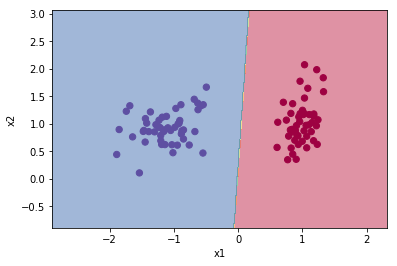

In [16]:
print(get_accuracy(model,X0,Y0))
plot_decision_boundary(model, X0, Y0)

### Train a Regularized Logistic Regression

<font color=blue size=4>*(ii)* Complete and run the code below.</font>

Change the loss function from above to the following:
$$
L(h_w| X,Y) = \sum_{i=1}^N \log\left(1 + \exp\left(- y.h_w(x)\right)\right) + \lambda ||w||^2
$$
where $h_w$ is the value obtained after a forward pass through a linear model. 

You can use the function `torch.norm()` to compute the norm and attribute `model.w.weight` to access the parameters inside a model variable. 

In [ ]:
lamda = 0.1 # regularization constant
lr = 0.001

model = LogRegModel()
optimizer = optim.Adam(model.parameters(), lr=lr)
for epoch in range(num_epochs):
    indices = torch.randperm(len(Y0))
    for i in range(len(Y0)):
        x, y = X0[indices[i]], Y0[indices[i]]
        optimizer.zero_grad()
        
        """
        ### TODO: FILL CODE HERE        
        """
        
        loss.backward()
        optimizer.step()

In [ ]:
print(get_accuracy(model,X0,Y0))
plot_decision_boundary(model, X0, Y0)

### Train a linear model with a Hinge loss (SVM)

To train the same linear model with a different objective, we just need to switch the loss function to a different loss. In this example, let's change the loss function to Hinge Loss:
Change the loss function to the following:
$$
L(h_w| X,Y) = \sum_{i=1}^N \max(0, 1-y.h_w(x)) + \lambda ||w||^2
$$
where $h_w$ is the value obtained after a forward pass.

<font color=blue size=4>*(iii)* Complete the code below to implement the above loss function</font>

In [ ]:
model = LogRegModel()
optimizer = optim.Adam(model.parameters(), lr=0.01)
for epoch in range(num_epochs):
    indices = torch.randperm(len(Y0))
    for i in range(len(Y0)):
        x, y = X0[indices[i]], Y0[indices[i]]
        optimizer.zero_grad()
                
        """
        ### TODO: FILL CODE HERE
        
        """
        loss.backward()
        optimizer.step()

In [ ]:
print(get_accuracy(model,X0,Y0))
plot_decision_boundary(model, X0, Y0)

## Dataset 1

For the second dataset, we will fit a Regularized Logistic regression model, a one-layer Neural network, a 3-layer Neural network

### Regularized Logistic Regression

In [ ]:
lamda = 0.1
lr = 0.01

model = LogRegModel()
optimizer = optim.Adam(model.parameters(), lr=lr)
for epoch in range(num_epochs):
    indices = torch.randperm(len(Y))
    for i in range(len(Y)):
        x, y = X[indices[i]], Y[indices[i]]
        optimizer.zero_grad()
               
        """
        FILL IN CODE HERE for regularized logistic loss from above
        """
                
        loss.backward()
        optimizer.step()

In [ ]:
print(get_accuracy(model,X,Y))
plot_decision_boundary(model, X, Y)

### One-hidden layer Neural Network
Let's use the logistic loss for a neural network

In [17]:
model = NNModel(hidden_layer=32)
optimizer = optim.Adam(model.parameters(), lr=0.01)
for epoch in range(num_epochs):
    indices = torch.randperm(len(Y))
    for i in range(len(Y)):
        x, y = X[indices[i]], Y[indices[i]]
        optimizer.zero_grad()
        loss = torch.log(1 + torch.exp(-y * model(x))) # use the logistic loss for the neural networks
        loss.backward()
        optimizer.step()

tensor(1.)


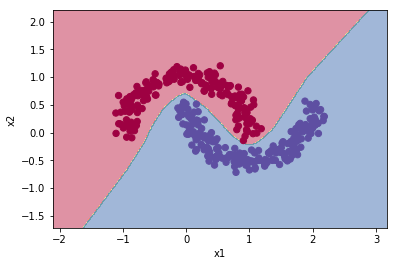

In [18]:
print(get_accuracy(model,X,Y))
plot_decision_boundary(model, X, Y)

<font color=blue size=4>*(iii)* Visualize the decision boundary for hidden layers of sizes 2,3, and 4. You can try different values of the learning rate for the three sizes.</font>

### 3-layer Neural network

<font color=blue size=4>*(iv)* Write to code to train the 3-layer neural network (DeepNNModel) on Dataset 1 below. Fix the size of 16 for all three hidden layers. You can try different learning rates.</font>

You should obtain a separating hyperplane similar to above. You can also tune the learning rate to get the best hyperplane.

In [ ]:
"""
Write code here

"""

In [ ]:
print(get_accuracy(model,X,Y))
plot_decision_boundary(model, X, Y)

## Dataset 2


<font color=blue size=4>
For the final dataset, complete the following:
    
*(v)* Train a Regularized Logistic Regression model for Dataset-2. Compute the accuracy and plot the decision boundary.

*(vi)* Train a 1-hidden layer Neural Network model for Dataset-2 for hidden layer of size 32. Compute the accuracy and plot the decision boundary.

*(vii)* Train a 1-hidden layer Neural Network model for Dataset-2 by varying hidden layer sizes from 2 to 16. For each size, run the training 5 times, compute the accuracy of each run. Plot the variation of average accuracy with hidden layer sizes. For each hidden layer size, also show the corresponding standard error as an error bar around the average, where $\texttt{stderr} = \sigma/\sqrt{5}$, where $\sigma$ is the standard deviation of the accuracies of 5 runs for a particular hidden layer size.

*(viii)* Train a Neural Network model with 3-hidden layer for Dataset-2. Compute the accuracy and plot the decision boundary.

*For all these parts, you can try different learning rates, number of epochs, and regularization parameter (for Regularized Logistic regression) to see what impact they have on the outcome.*
</font>

<font size=4 color=blue> Once done, go to `File>Download as>PDF` to save the notebook as a PDF, attach it to the rest of your submission and submit alongside the assignment on Gradescope and CMS.</font> 

If for some reason saving as PDF doesnt work for you, save it as a HTML and try save/print as PDF in your computer browser. 